In [1]:
import pandas as pd
import numpy as np
from scipy import stats

# Crear dataset con missing values y outliers
np.random.seed(42)
n = 1000

datos = pd.DataFrame({
    'id': range(1, n+1),
    'edad': np.random.normal(35, 10, n).clip(18, 80),  # Normal con límites
    'salario': np.random.lognormal(10, 0.5, n),  # Distribución log-normal
    'horas_trabajo': np.random.normal(40, 5, n).clip(20, 60),
    'satisfaccion': np.random.randint(1, 6, n),
    'departamento': np.random.choice(['IT', 'Ventas', 'Marketing', 'HR'], n)
})

# Introducir missing values
mask_missing = np.random.random(n) < 0.1  # 10% missing
datos.loc[mask_missing, 'salario'] = np.nan

mask_missing_horas = np.random.random(n) < 0.05  # 5% missing
datos.loc[mask_missing_horas, 'horas_trabajo'] = np.nan

# Introducir outliers
outlier_indices = np.random.choice(n, 20, replace=False)
datos.loc[outlier_indices[:10], 'salario'] = datos.loc[outlier_indices[:10], 'salario'] * 10  # Salarios extremos altos
datos.loc[outlier_indices[10:], 'horas_trabajo'] = np.random.choice([80, 90, 100], 10)  # Horas imposibles

print(f"Dataset creado: {datos.shape}")
print(f"Valores faltantes por columna:\n{datos.isnull().sum()}")

Dataset creado: (1000, 6)
Valores faltantes por columna:
id                0
edad              0
salario          95
horas_trabajo    46
satisfaccion      0
departamento      0
dtype: int64


In [2]:
datos

,id,edad,salario,horas_trabajo,satisfaccion,departamento
0,1,39.967142,44341.562353,36.624109,4,Ventas
1,2,33.617357,34972.483357,39.277407,2,HR
2,3,41.476885,22693.077136,36.037900,1,Marketing
3,4,50.230299,15939.117886,38.460192,2,Ventas
4,5,32.658466,31229.288168,30.531927,5,Marketing
...,...,...,...,...,...,...
995,996,32.188997,37611.875571,40.387403,1,Ventas
996,997,52.976865,21736.309072,41.288763,4,HR
997,998,41.408429,14172.555672,33.791197,3,IT
998,999,29.288210,20301.834249,NaN,1,Ventas


In [7]:
# Análisis detallado de missing values
print("Porcentaje de datos faltantes:")
print((datos.isnull().sum() / len(datos) * 100).round(2))

# Patrón de missing values
import missingno as msno
# msno.matrix(datos)  # Visualización (requiere instalar missingno)

# Análisis por departamento
print("\nMissing values por departamento:")
print(datos.groupby('departamento').apply(lambda x: x.isnull().sum()))

Porcentaje de datos faltantes:
id               0.0
edad             0.0
salario          9.5
horas_trabajo    4.6
satisfaccion     0.0
departamento     0.0
dtype: float64

Missing values por departamento:
              id  edad  salario  horas_trabajo  satisfaccion  departamento
departamento                                                              
HR             0     0       20             13             0             0
IT             0     0       18              3             0             0
Marketing      0     0       23             17             0             0
Ventas         0     0       34             13             0             0


C:\Users\nico_\AppData\Local\Temp\ipykernel_15492\3742569873.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(datos.groupby('departamento').apply(lambda x: x.isnull().sum()))


<Axes: >

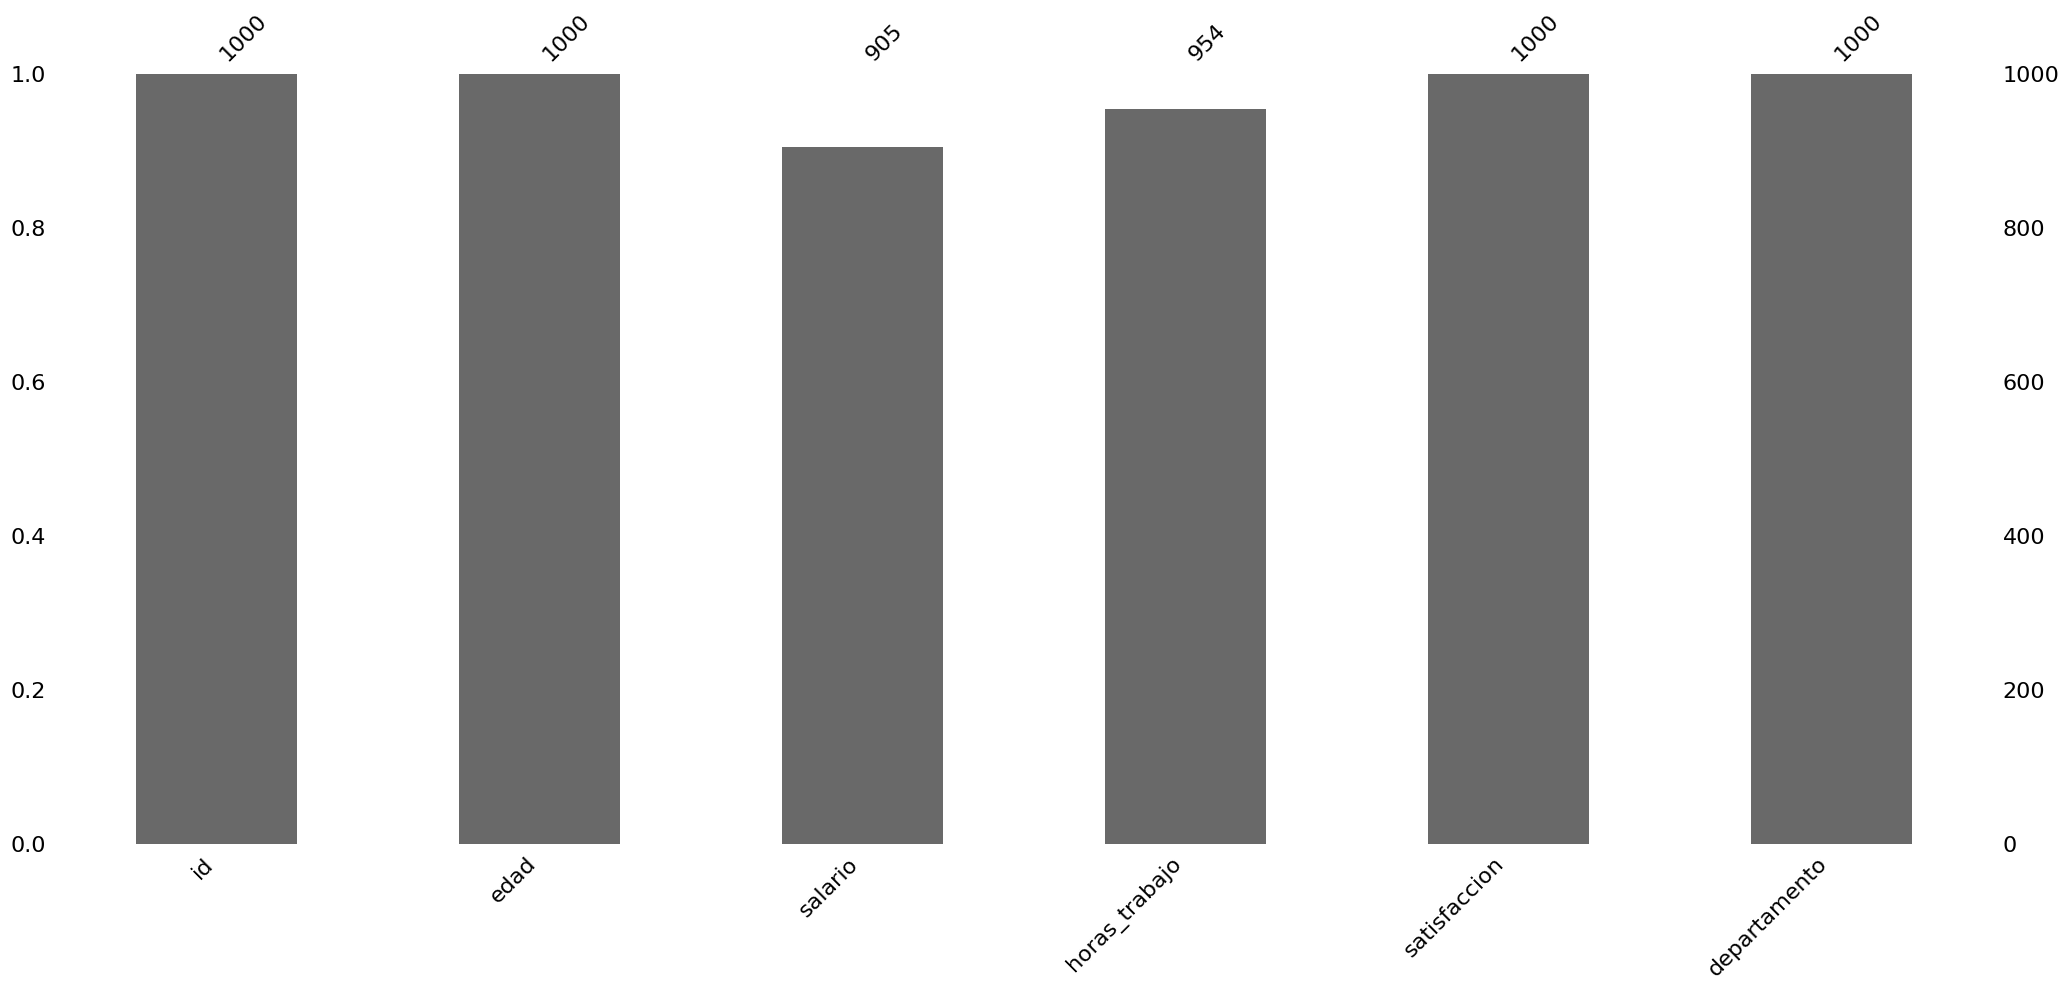

In [10]:
msno.bar(datos)


In [11]:
# Imputación por media para horas_trabajo
media_horas = datos['horas_trabajo'].mean()
datos['horas_trabajo'] = datos['horas_trabajo'].fillna(media_horas)

# Imputación por mediana para salario (más robusto a outliers)
mediana_salario = datos['salario'].median()
datos['salario'] = datos['salario'].fillna(mediana_salario)

# Verificar que no queden missing values
print(f"\nValores faltantes después de imputación: {datos.isnull().sum().sum()}")


Valores faltantes después de imputación: 0


In [12]:
# Función para detectar outliers usando IQR
def detectar_outliers_iqr(data, columna):
    Q1 = data[columna].quantile(0.25)
    Q3 = data[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    return (data[columna] < limite_inferior) | (data[columna] > limite_superior)

# Detectar outliers en salario y horas
outliers_salario = detectar_outliers_iqr(datos, 'salario')
outliers_horas = detectar_outliers_iqr(datos, 'horas_trabajo')

print(f"\nOutliers detectados:")
print(f"Salario: {outliers_salario.sum()} ({outliers_salario.mean()*100:.1f}%)")
print(f"Horas trabajo: {outliers_horas.sum()} ({outliers_horas.mean()*100:.1f}%)")


Outliers detectados:
Salario: 55 (5.5%)
Horas trabajo: 24 (2.4%)


In [13]:
# Para horas_trabajo: cap at reasonable maximum
max_horas_normales = 60
datos.loc[datos['horas_trabajo'] > max_horas_normales, 'horas_trabajo'] = max_horas_normales

# Para salario: transformar usando log (más robusto)
datos['salario_log'] = np.log1p(datos['salario'])

# Comparar estadísticas antes y después
print(f"\nEstadísticas de salario original:")
print(datos['salario'].describe().round(2))

print(f"\nEstadísticas de salario transformado (log):")
print(datos['salario_log'].describe().round(2))

# Verificar reducción de outliers
outliers_salario_log = detectar_outliers_iqr(datos, 'salario_log')
print(f"\nOutliers en salario log-transformado: {outliers_salario_log.sum()}")


Estadísticas de salario original:
count      1000.00
mean      28034.05
std       31587.51
min        5063.46
25%       17302.19
50%       22873.10
75%       30819.42
max      518367.29
Name: salario, dtype: float64

Estadísticas de salario transformado (log):
count    1000.00
mean       10.06
std         0.53
min         8.53
25%         9.76
50%        10.04
75%        10.34
max        13.16
Name: salario_log, dtype: float64

Outliers en salario log-transformado: 29
